## Importing Libraries

In [1]:
import time
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional  as f
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import IPython
import torchvision
import numpy as np

## Setting Device to GPU for faster training

In [2]:
import torch
print(torch.__version__)

1.10.0+cu113


In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

## One Hot Encoding

In [4]:
class_dict = pd.read_csv('class_dict.csv')
# Get class names
class_names = class_dict['name'].tolist()
print(class_names)
class_labels = [index for index,label in enumerate(class_names)]
print(class_labels)
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()
print(class_rgb_values)

['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
[0, 1, 2, 3, 4, 5, 6]
[[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


## Custom Dataset For Training Images

In [5]:
class SatelliteImagesTrain(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.csv_file = pd.read_csv(csv_file)
        self.transform = transform
        self.split = split
        self.class_labels = [[0, 1, 1], [1, 1, 0], [1, 0, 1], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 0, 0]]
        
#     def get_pixel_class_map(self,mask_img):
#         concat = []
#         for idx, rgb_combo in enumerate(self.class_labels):
#             x = torch.eq(mask_img.permute(1,2,0).type(torch.int64), torch.tensor(rgb_combo).unsqueeze(0).unsqueeze(0))
#             x_and = torch.logical_and(torch.logical_and(x[:,:,0],x[:,:,1]),x[:,:,2])
#             t = x_and.long()
#             t[t == 1] = 1
#             concat.append(t.unsqueeze(0))
            
#         return torch.cat((concat[0],concat[1],concat[2],concat[3],concat[4],concat[5],concat[6]),dim = 0)

    def get_pixel_class_map(self,mask_img):
        concat = torch.zeros((mask_img.size(1),mask_img.size(2)))
        for idx, rgb_combo in enumerate(self.class_labels):
            x = torch.eq(mask_img.permute(1,2,0).type(torch.int64), torch.tensor(rgb_combo).unsqueeze(0).unsqueeze(0))
            x_and = torch.logical_and(torch.logical_and(x[:,:,0],x[:,:,1]),x[:,:,2])
            t = x_and.long()
            concat[t == 1] = idx
            
        return concat
    
    def __len__(self):
        return len(self.csv_file.where(self.csv_file["split"] == self.split).dropna(axis = 0, how = 'all'))

    def __getitem__(self, index):
        sat_img_path = self.csv_file["sat_image_path"].where(self.csv_file["split"] == self.split).dropna(axis = 0, how = 'all')[index]
        mask_img_path = self.csv_file["mask_path"].where(self.csv_file["split"] == self.split).dropna(axis = 0, how = 'all')[index]
        sat_img = Image.open(sat_img_path).convert("RGB")
        mask_img = Image.open(mask_img_path).convert("RGB")
        
        if self.transform is not None:
            sat_img = self.transform(sat_img)
            mask_img = self.transform(mask_img)

        return (sat_img, self.get_pixel_class_map(mask_img))

## Custom Dataset for validation and test set

In [6]:
class SatelliteImagesTestValid(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.csv_file = pd.read_csv(csv_file)
        self.transform = transform
        self.split = split
        
        
    def __len__(self):
        return len(self.csv_file.where(self.csv_file["split"] == self.split).dropna(axis = 0, how = 'all').reset_index(drop = True))

    def __getitem__(self, index):
        sat_img_path = self.csv_file["sat_image_path"].where(self.csv_file["split"] == self.split).dropna(axis = 0, how = 'all').reset_index(drop = True)[index]
        sat_img = Image.open(sat_img_path).convert("RGB")
        
        if self.transform is not None:
            sat_img = self.transform(sat_img)

        return sat_img

In [7]:
transform = transforms.Compose([
                               transforms.Resize((512,512)),
                               transforms.ToTensor()
                               ])

In [8]:
train_dataset = SatelliteImagesTrain(csv_file = "metadata.csv",split = "train", transform = transform)

In [9]:
valid_dataset = SatelliteImagesTestValid(csv_file = "metadata.csv",split = "valid", transform = transform)

In [10]:
test_dataset = SatelliteImagesTestValid(csv_file = "metadata.csv",split = "test", transform = transform)

In [11]:
len(train_dataset)

803

In [12]:
len(valid_dataset)

171

In [13]:
len(test_dataset)

172

## Model

In [14]:
class Model(torch.nn.Module):
    def __init__(self, n_classes = 7, channels = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding = 'same')
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(4, 8, kernel_size=3, padding = 'same')
        self.dropout2 = nn.Dropout(0.2)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(8, 16, kernel_size=3, padding = 'same')
        self.dropout3 = nn.Dropout(0.2)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv7 = nn.Conv2d(16, 32, kernel_size=3, padding = 'same')
        self.dropout4 = nn.Dropout(0.2)
        self.conv8 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv9 = nn.Conv2d(32, 64, kernel_size=3, padding = 'same')
        self.dropout5 = nn.Dropout(0.2)
        self.conv10 = nn.Conv2d(64, 64, kernel_size=3, padding = 'same')

        self.transConv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(64, 32, kernel_size=3, padding = 'same')
        self.dropout6 = nn.Dropout(0.2)
        self.conv12 = nn.Conv2d(32, 32, kernel_size=3, padding = 'same')

        self.transConv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(32, 16, kernel_size=3, padding = 'same')
        self.dropout7 = nn.Dropout(0.2)
        self.conv14 = nn.Conv2d(16, 16, kernel_size=3, padding = 'same')

        self.transConv3 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(16, 8, kernel_size=3, padding = 'same')
        self.dropout8 = nn.Dropout(0.2)
        self.conv16 = nn.Conv2d(8, 8, kernel_size=3, padding = 'same')

        self.transConv4 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(8, 4, kernel_size=3, padding = 'same')
        self.dropout9 = nn.Dropout(0.2)
        self.conv18 = nn.Conv2d(4, 4, kernel_size=3, padding = 'same')

        self.final_conv = nn.Conv2d(4, n_classes, kernel_size=1, padding = 'same')

    def forward(self, x):
        """ Encoder """
        x1 = nn.ReLU()(self.conv1(x))
        x1 = self.dropout1(x1)
        x1 = nn.ReLU()(self.conv2(x1))
        p1 = self.maxpool1(x1)

        x2 = nn.ReLU()(self.conv3(p1))
        x2 = self.dropout2(x2)
        x2 = nn.ReLU()(self.conv4(x2))
        p2 = self.maxpool2(x2)

        x3 = nn.ReLU()(self.conv5(p2))
        x3 = self.dropout3(x3)
        x3 = nn.ReLU()(self.conv6(x3))
        p3 = self.maxpool3(x3)

        x4 = nn.ReLU()(self.conv7(p3))
        x4 = self.dropout4(x4)
        x4 = nn.ReLU()(self.conv8(x4))
        p4 = self.maxpool4(x4)

        """Transfer block"""
        x5 = nn.ReLU()(self.conv9(p4))
        x5 = self.dropout5(x5)
        x5 = nn.ReLU()(self.conv10(x5))

        """ Decoder """
        u6 = self.transConv1(x5)
        u6 = torch.cat((u6, x4), 1)
        x6 = nn.ReLU()(self.conv11(u6))
        x6 = self.dropout6(x6)
        x6 = nn.ReLU()(self.conv12(x6))

        u7 = self.transConv2(x6)
        u7 = torch.cat((u7, x3), 1)
        x7 = nn.ReLU()(self.conv13(u7))
        x7 = self.dropout7(x7)
        x7 = nn.ReLU()(self.conv14(x7))

        u8 = self.transConv3(x7)
        u8 = torch.cat((u8, x2), 1)
        x8 = nn.ReLU()(self.conv15(u8))
        x8 = self.dropout8(x8)
        x8 = nn.ReLU()(self.conv16(x8))

        u9 = self.transConv4(x8)
        u9 = torch.cat((u9, x1), 1)
        x9 = nn.ReLU()(self.conv17(u9))
        x9 = self.dropout9(x9)
        x9 = nn.ReLU()(self.conv18(x9))

        '''Classifier'''
        output = self.final_conv(x9)
        return output

## Hyperparameters

In [15]:
# Hyperparameters
num_epochs = 3
learning_rate = 0.001
batch_size = 16
shuffle = True
pin_memory = True
num_workers = 0

## Creating dataloaders for train,valid, test from custom datasets

In [16]:
train_loader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
validation_loader = DataLoader(dataset=valid_dataset, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_dataset, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

## Setting the loss function, optimizer and learning rate

In [17]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Helper Function to check IOU

In [18]:
# pending

## Training Loop

In [19]:
epoch_loss_list = []
loop = tqdm(range(num_epochs),total = num_epochs)
for epoch in loop:
    epoch_loss = 0
    for sat_img, mask_img in train_loader:
        # Forward Propagation:
        sat_img = sat_img.to(device)
        mask_img = mask_img.type(torch.LongTensor).to(device)
        output = model(sat_img)
        # Backward Propagation:
        loss = criterion(output, mask_img)
        epoch_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix({"Loss_batch":loss.item()})
    epoch_loss_list.append(epoch_loss/(len(train_dataset) / batch_size))
    loop.set_postfix({"Loss_Epoch":epoch_loss/(len(train_dataset) / batch_size)})

  0%|          | 0/3 [00:00<?, ?it/s]

## Epoch Loss Plot

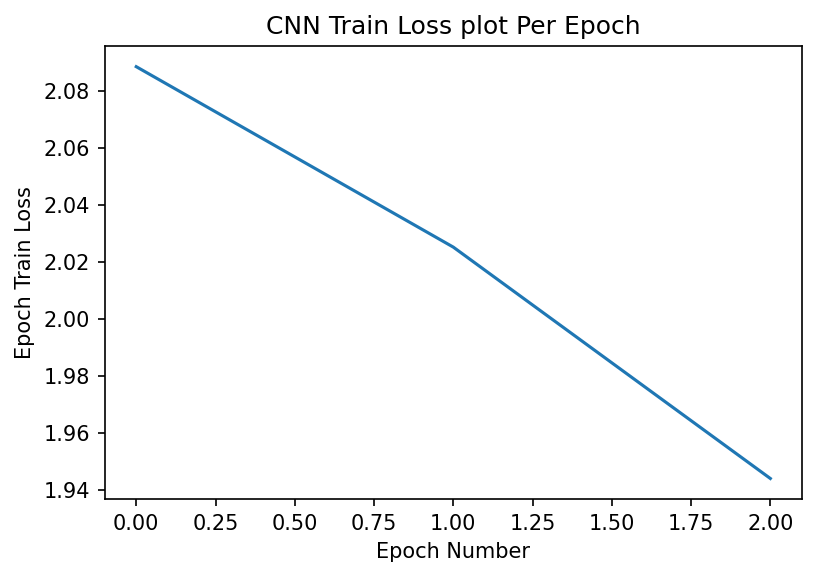

In [20]:
## Plot Epoch Loss:
plt.figure(dpi=150)
plt.plot([epoch for epoch in range(num_epochs)], epoch_loss_list)
plt.xlabel("Epoch Number")
plt.ylabel("Epoch Train Loss")
plt.title("CNN Train Loss plot Per Epoch")
plt.show()

In [37]:
def pred_to_img(pred):
    init_arr = torch.argmax(pred,dim = 1)
    r_channel = torch.zeros((pred.size(0), pred.size(2), pred.size(3)))
    g_channel = torch.zeros((pred.size(0), pred.size(2), pred.size(3)))
    b_channel = torch.zeros((pred.size(0), pred.size(2), pred.size(3)))
    
    class_labels = [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]
    
    for i in range(pred.size(1)):
        r_channel[init_arr == i] = class_labels[i][0]
        g_channel[init_arr == i] = class_labels[i][1]
        b_channel[init_arr == i] = class_labels[i][2]
        
    return torch.cat((r_channel.unsqueeze(1),g_channel.unsqueeze(1),b_channel.unsqueeze(1)),dim = 1)       

In [38]:
for sat_img in test_loader:
    output = model(sat_img.to(device))
    break

In [39]:
print(class_labels)
print(class_rgb_values)

[0, 1, 2, 3, 4, 5, 6]
[[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [40]:
list_tensors = pred_to_img(output)

In [41]:
grid_imgs = torchvision.utils.make_grid(list_tensors, nrow=4)

In [42]:
grid_imgs.size()

torch.Size([3, 2058, 2058])

In [43]:
# source: https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


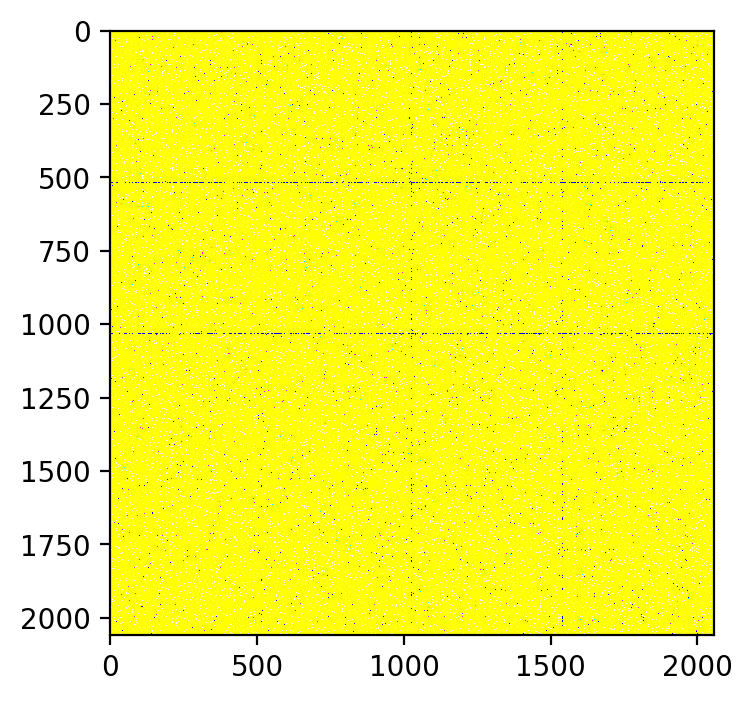

In [44]:
f = plt.figure(dpi=200)
show(grid_imgs)